# Simulated landscapes

This notebook runs faster on GPU; you can upload it to Google Colab and run it there, if you do not have a GPU on your local machine.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys

In [2]:
device = (torch.device('cuda') if torch.cuda.is_available() else 
          torch.device('mps') if torch.backends.mps.is_available() else
          torch.device('cpu'))


In [3]:
sys.path.insert(0, '..')
sys.path.insert(0, '../..')
import ecoscape_connectivity


In [4]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = 'cpu'
print("Device:", device)

Device: mps


## Test habitats and terrains

In [5]:
def simulate(hab, ter,
             seed_density=4.0, batch_size=5, dispersal=25, 
             num_simulations=400, gap_crossing=0):
    """
    Function that makes simulating and displaying repopulation easier.
    """

    # analyze_tile expects the habitat to be of shape (1, w, h)
    if np.ndim(hab) == 2:
        hab = np.expand_dims(hab, axis=0)

    repopulate = ecoscape_connectivity.analyze_tile_torch(
        device=device,
        seed_density=seed_density,
        produce_gradient=True,
        batch_size=batch_size,
        dispersal=dispersal,
        num_simulations=num_simulations,
        gap_crossing=gap_crossing)

    repop, grad = repopulate(hab, ter)

    # a bit of reshaping for displaying with matplotlib
    hab = np.sum(hab, 0)
    repop = np.sum(repop.detach().cpu().numpy(), 0)
    grad = np.log10(1 + np.sum(grad.detach().cpu().numpy(), 0))

    return repop, grad

In [6]:
def draw_circle(hab, y, x, r):
    return np.maximum(hab, (X - x) ** 2 + (Y - y) ** 2 < r ** 2)

In [7]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm

In [8]:
import matplotlib.cm as cm

inferno = cm.inferno(np.linspace(0, 1, 256))
last_color = inferno[-1]
last_color

array([0.988362, 0.998364, 0.644924, 1.      ])

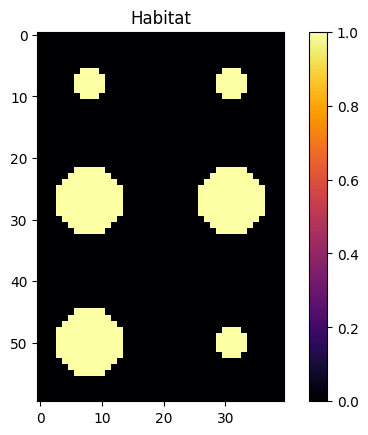

In [9]:
# habitat for testing resistance vs dispersal distance
Xdim = 40
Ydim = 60

Y, X = np.meshgrid(range(0, Xdim), range(0, Ydim))

hab = np.zeros((Ydim, Xdim))
hab = draw_circle(hab, 31, 50, 2.5) # c1
hab = draw_circle(hab, 31, 27, 5.5) # c2
hab = draw_circle(hab, 31, 8, 2.5) # c3
hab = draw_circle(hab, 8, 8, 2.5) # c4
hab = draw_circle(hab, 8, 27, 5.5) # c5
hab = draw_circle(hab, 8, 50, 5.5) # c6

plt.imshow(hab, cmap='inferno')
plt.colorbar()
plt.title('Habitat')
plt.show()

In [10]:
cdict = {
    'red': (
        (0.0,  0.0, 0.0),
        (0.95,  0.0, 0.0),
        (1.0, 0.4, 0.4),
    ),
    'green': (
        (0.0,  0.0, 0.0),
        (0.95,  0.3, 0.3),
        (1.0, 1, 1),
    ),
    'blue': (
        (0.0,  0.0, 0.0),
        (0.95,  0.0, 0.0),
        (1.0,  0.4, 0.4),
    )
}
habitat_cmap = LinearSegmentedColormap('habitat_cmap', cdict)

In [11]:
cdict = {
    'red': (
        (0.0,  0.0, 0.0),
        (0.95,  0, 0),
        (1.0, 0.5, 0.5),
    ),
    'green': (
        (0.0,  0.0, 0.0),
        (0.95,  0.3, 0.3),
        (1.0, 1.0, 1.0),
    ),
    'blue': (
        (0.0,  0.0, 0.0),
        (0.95,  0, 0),
        (1.0,  0.5, 0.5),
    )
}
habitat_cmap = LinearSegmentedColormap('habitat_cmap', cdict)

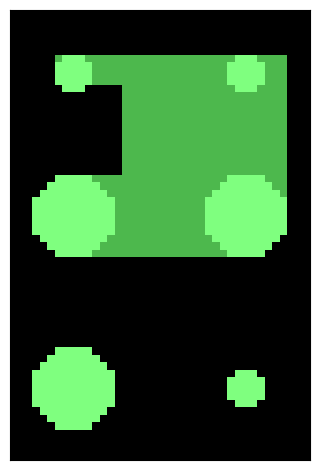

In [12]:
corridor = 0.98
ter = np.zeros_like(hab)
ter[6:10, 6:36] = corridor
ter[6:30, 15:37] = corridor
ter[22:33, 6:32] = corridor

total = np.maximum(hab, ter)
plt.imshow(total, cmap=habitat_cmap)
# plt.title('Habitat and terrain')
# Remove x tiks from the plot
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig("artificial_landscape.pdf", bbox_inches="tight", format="pdf")

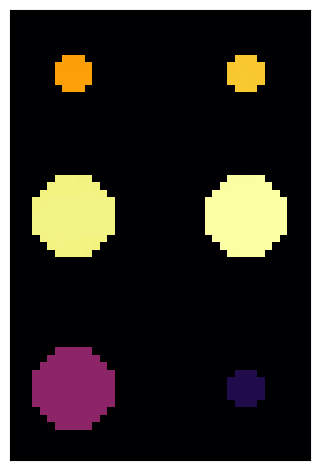

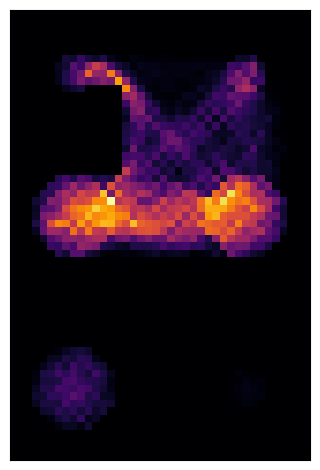

In [15]:
repop, grad = simulate(hab, ter,
             seed_density=4.0, batch_size=200, dispersal=100, 
             num_simulations=10000, gap_crossing=0)
plt.imshow(repop, cmap='inferno')
# plt.colorbar(shrink=0.5)
# plt.title("Repopulation")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig("connectivity.pdf", bbox_inches="tight", format="pdf")
plt.show()
plt.imshow(grad, cmap='inferno')
# plt.colorbar(shrink=0.5)
# plt.title("Flow")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig("flow.pdf", bbox_inches="tight", format="pdf")
plt.show()